In [9]:
%matplotlib inline

import os
import sys
import timeit
import urllib
import gzip
import pickle
from functools import reduce

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import Ridge
import pandas as pd
sys.path.append(os.path.abspath('..\\..\\..\\dataset'))

import dataset as ds
from dataset.opensets import MNIST
from dataset import B, V, C, F
from dataset import action
from dataset.models.tf import VGG7, VGG16, VGG19
from dataset.models.tf import VNet
from dataset.models.tf import UNet
from dataset.models.tf import SqueezeNet
from dataset.models.tf import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from dataset.models.tf import MobileNet
from dataset.models.tf import LinkNet
from dataset.models.tf import Inception_v1, Inception_v3, Inception_v4
from dataset.models.tf import FCN8, FCN16, FCN32
from dataset.models.tf import DenseNet121, DenseNet169, DenseNet201, DenseNet264
from dataset import Pipeline

from MNISTBatch import AugmentedMNISTBatch

import seaborn as sns

In [10]:
mnist_set = MNIST(batch_class=AugmentedMNISTBatch)

ExtractingExtractingExtractingExtracting   C:\Users\GREGOR~1\AppData\Local\Temp\train-images-idx3-ubyte.gz C:\Users\GREGOR~1\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\GREGOR~1\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\GREGOR~1\AppData\Local\Temp\t10k-images-idx3-ubyte.gz





In [11]:
def show_img(axis, image, title, grey=False):
    if grey:
        axis.imshow(image, cmap=plt.get_cmap('Greys'))
    else:
        axis.imshow(image)
    axis.set_title(title, fontsize=12)
    axis.tick_params(bottom='off', labelbottom='off', left='off', labelleft='off')

def plot_examples(title, action, **params):
    num_plots = 2 * len(list(params.values())[0])
    f, a = plt.subplots(1, num_plots, figsize=(16, 8))
    for i in range(num_plots // 2):
        batch = mnist_set.train.next_batch(1)
        current_params = {k : v[i] for k, v in params.items()}
        show_img(a[i*2], batch.images[0].squeeze(), 'original', True)
        action(batch, **current_params)
        title_action = '\n'.join((str(k)+'=' + str(v if not callable(v) else 'sampler') for k, v in current_params.items()))        
        show_img(a[i*2+1], batch.images[0].squeeze(), title_action)
    plt.suptitle(title, fontsize=18)

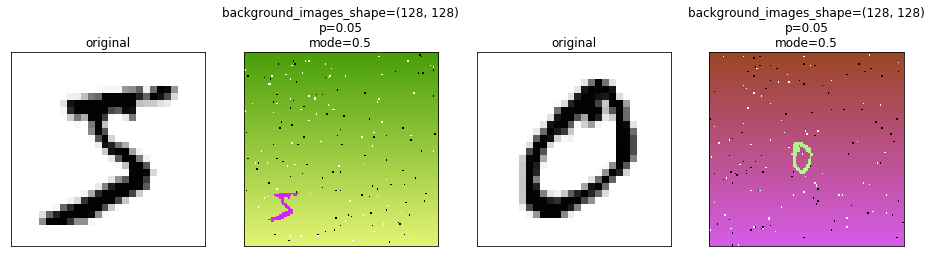

In [12]:
rotate_sampler = lambda: np.random.normal(0, 20)

def action(batch, **current_params):
    batch.rotate(p=1., angle=rotate_sampler)
    batch.truncate(threshold=128)
    batch.colorize()
    batch.put_on_image(background_images_shape=(128,128))
    batch.salt_and_pepper(mode=.5, p=0.01)

plot_examples(title = '',
              action = action,
              background_images_shape =  [(128,128)]*2,
              p = [0.05]*2,
              mode = [0.5]*2)

In [13]:
pipeline = (Pipeline()
         .init_variable('model_arch', MobileNet)
         .init_variable('accuracies', init_on_each_run=list)
         .init_model('dynamic', V('model_arch'), 'model',
                     config={'output' : {'ops' : 'accuracy'},
                             'inputs' : {'images': {'name': 'resized_images', 'shape': B('image_shape'),
                                                    'data_format':'channels_last'},
                                         'labels': {'classes': 10, 'transform': 'ohe', 'name': 'targets'}},
                             'loss' : 'ce',
                             'optimizer': ('GradientDescent', {'learning_rate' : 0.01}),
                             'input_block/inputs' : 'images'})
         .rotate(p=1., angle=rotate_sampler)
         .truncate(threshold=128)
         .colorize()
         .put_on_image(background_images_shape=(128,128))
         .salt_and_pepper(mode=.5, p=0.01)
         .normalize()
         .train_model('model',
                      fetches='output_accuracy',
                      feed_dict={'images': B('images'),
                                 'labels': B('labels')},
                      save_to=V('accuracies'), mode='a'))

# train_pipeline = pipeline + Pipeline()



In [6]:
def get_pipeline(template_pipeline, dataset, pipeline_variables={}, model_config={}):
    pipeline = template_pipeline << dataset    
    for variable, value in pipeline_variables.items():
        pipeline.set_variable(variable, value)
    pipeline.set_config(model_config)
    return pipeline


In [7]:
def conduct_experiments(model, batch_size=32, n_epochs=6):
    train_pipeline =pipeline << mnist_set.train
    train_pipeline.set_variable('model_arch', model) 
    for i, batch in tqdm(enumerate(train_pipeline.gen_batch(batch_size,shuffle=True,n_epochs=6, prefetch=1))):
        if (i % 500 == 0):  
            acc = train_pipeline.get_variable('accuracies')
            print(i, np.mean(acc[-500:]))
    return train_pipeline.get_variable('accuracies'), train_pipeline

def plot_accuracy(accuracy, model_name, smooth_factor=500):
    plt.figure(figsize=(16,9))
    plt.plot(np.convolve(accuracy, np.ones(smooth_factor), mode='valid')/smooth_factor)
    plt.title(model_name)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')

In [13]:
acc_mobilenet = conduct_experiments(MobileNet, batch_size=32, n_epochs=6)

A Jupyter Widget

0 0.125
500 0.100313
1000 0.100625
1500 0.102375
2000 0.104375
2500 0.106
3000 0.104625
3500 0.104625
4000 0.101375
4500 0.109125
5000 0.108687
5500 0.103562
6000 0.110625
6500 0.111562
7000 0.108687
7500 0.104062
8000 0.105375
8500 0.106188
9000 0.107688
9500 0.108313
10000 0.107437
10500 0.106688
11000 0.105563


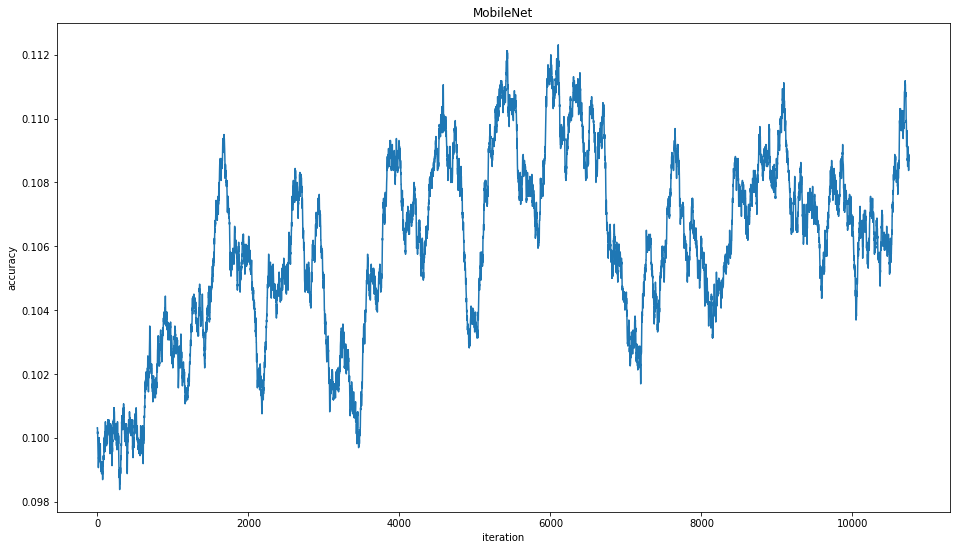

In [19]:
plot_accuracy(acc_mobilenet, 'MobileNet')

A Jupyter Widget

0 0.15625
500 0.103562
1000 0.100375
1500 0.104062
2000 0.1025
2500 0.101625
3000 0.098
3500 0.10275
4000 0.0990625
4500 0.0978125
5000 0.0990625
5500 0.0998125
6000 0.1015
6500 0.102812
7000 0.0995
7500 0.10725
8000 0.10325
8500 0.1035
9000 0.102375
9500 0.101438
10000 0.102563
10500 0.101375
11000 0.107562



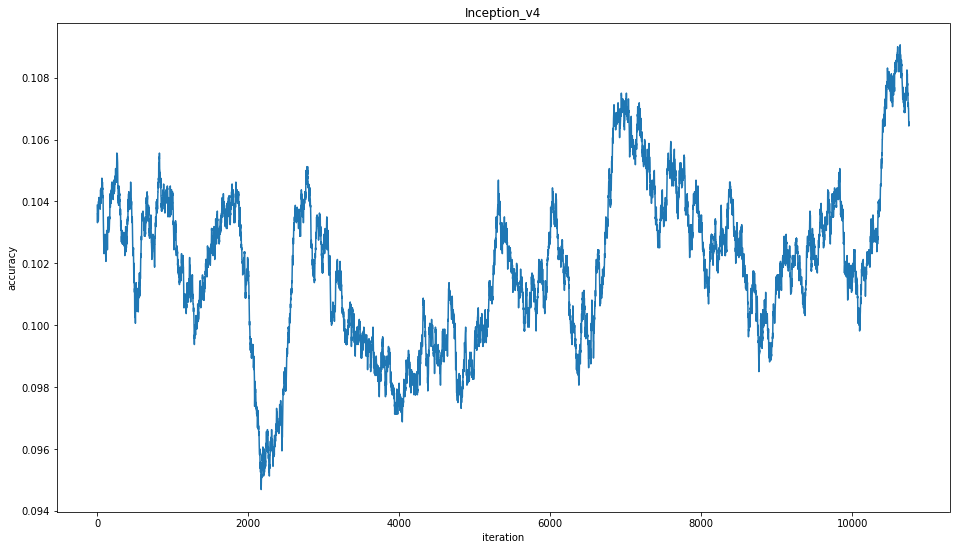

In [14]:
acc_inception, inception_v4_pipe = conduct_experiments(Inception_v4, batch_size=32, n_epochs=6)
plot_accuracy(acc_inception, 'Inception_v4')

In [22]:
acc_squeezenet = conduct_experiments(SqueezeNet, batch_size=32, n_epochs=6)

A Jupyter Widget

0 0.125
500 0.101438
1000 0.107313
1500 0.103
2000 0.107188
2500 0.110563
3000 0.1065
3500 0.112125
4000 0.114375
4500 0.1085
5000 0.112
5500 0.108562
6000 0.112438
6500 0.11475
7000 0.111625
7500 0.110437
8000 0.110437
8500 0.114125
9000 0.115375
9500 0.113312
10000 0.112938
10500 0.112313
11000 0.113438



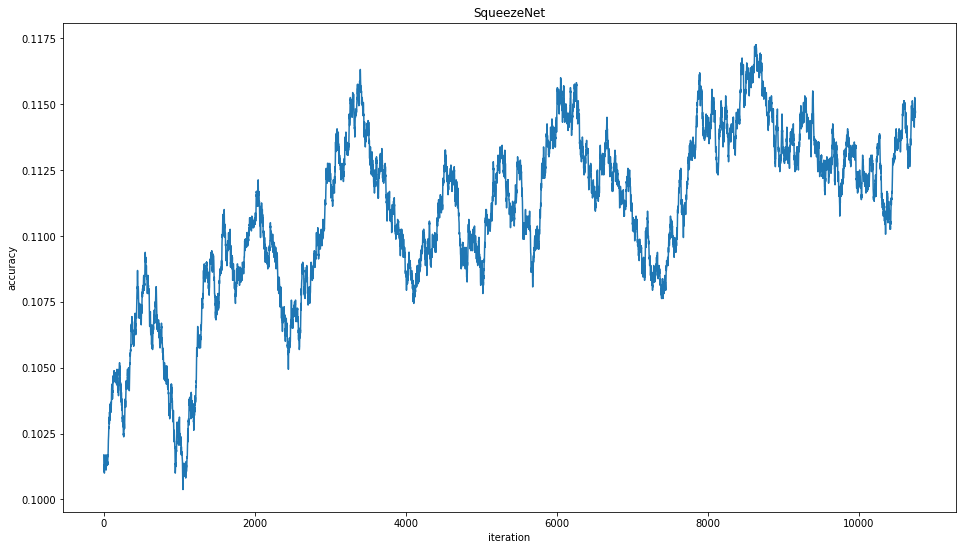

In [23]:
plot_accuracy(acc_squeezenet, 'SqueezeNet')

In [20]:
acc_resnet50 = conduct_experiments(ResNet50, batch_size=32, n_epochs=6)

A Jupyter Widget

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gregory Ivanov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



0 0.15625
500 0.0968125
1000 0.098125
1500 0.09825
2000 0.098
2500 0.100125
3000 0.10225
3500 0.1035
4000 0.101062
4500 0.108625
5000 0.10775
5500 0.110125
6000 0.110063
6500 0.109125
7000 0.116187
7500 0.137688
8000 0.165063
8500 0.189187
9000 0.229625
9500 0.306875
10000 0.414125
10500 0.5495
11000 0.651312



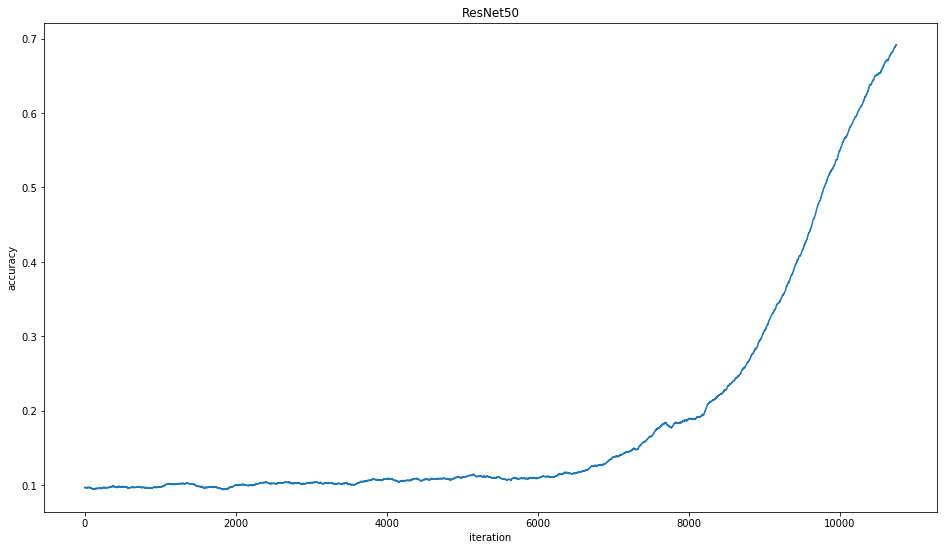

In [21]:
plot_accuracy(acc_resnet50, 'ResNet50')

In [ ]:
# resnet_pipeline =pipeline << mnist_set.train
resnet_pipeline.set_variable('model_arch', ResNet50) 
for i, batch in tqdm(enumerate(resnet_pipeline.gen_batch(batch_size,shuffle=True,n_epochs=18, prefetch=1))):
    if (i % 500 == 0):
        acc = resnet_pipeline.get_variable('accuracies')
        print(i, np.mean(acc[-500:]))
acc_resnet50 = resnet_pipeline.get_variable('accuracies')

In [ ]:
t_pipeline = (Pipeline()
         .import_model('model', resnet_pipeline)
         .init_variable('accuracies', init_on_each_run=list)
         .rotate(p=1., angle=rotate_sampler)
         .truncate(threshold=128)
         .colorize()
         .put_on_image(background_images_shape=(128,128))
         .salt_and_pepper(mode=.5, p=0.01)
         .normalize()
         .predict_model('model', fetches='output_accuracy',
                        feed_dict={'images': B('images'),
                                   'labels': B('labels')},
                        save_to=V('accuracies'), mode='a'))
test_pipeline = t_pipeline << mnist_set.test

test_pipeline.run(batch_size=32, n_epochs=3)

In [ ]:
resnet_test_accuracy = np.mean(test_pipeline.get_variable('accuracies'))
print('test accuracy for ResNet50 is {0:.3f}'.format(resnet_test_accuracy))

Was about 95.2 %